In [1]:
%matplotlib inline

import os
import tarfile
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from six.moves import urllib

from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.svm import SVR

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


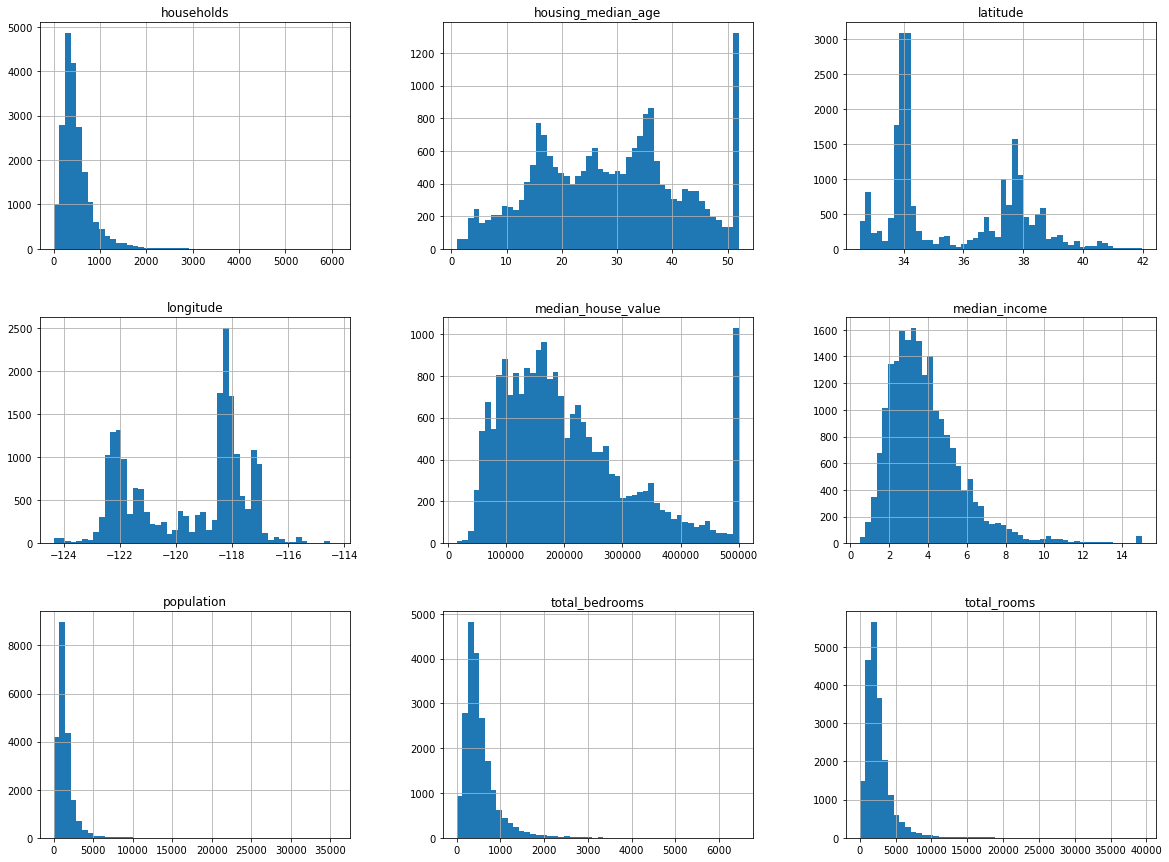

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
train_test, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
for set_ in (strat_train_set, strat_test_set):
    if "income_cat" in set_.columns:
        set_.drop("income_cat", axis=1, inplace=True)

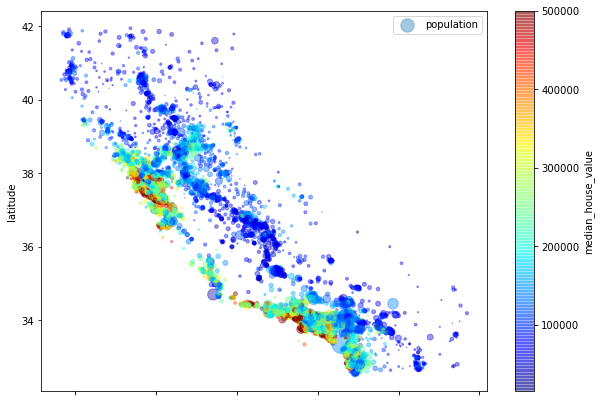

In [17]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100,
            label="population",
            figsize=(10,7),
            c="median_house_value",
            cmap=plt.get_cmap("jet"),
            colorbar=True)
plt.legend()
plt.show()

In [18]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

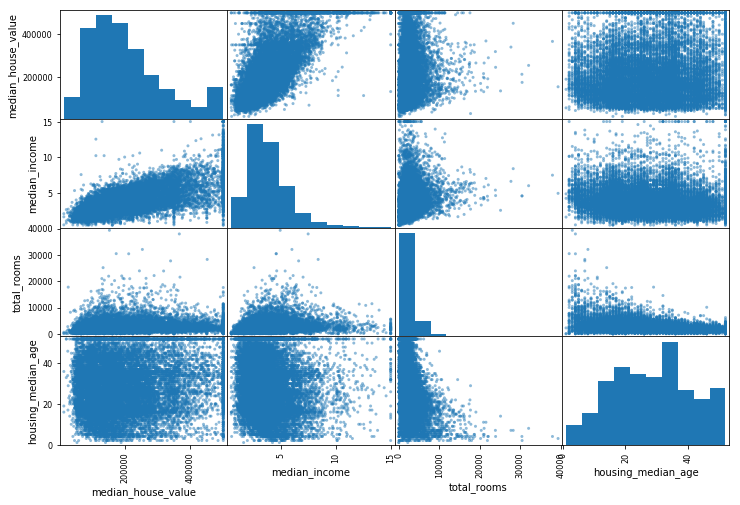

In [19]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

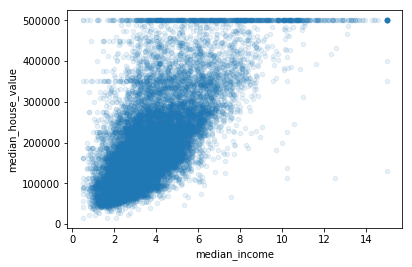

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [23]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [24]:
imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [25]:
imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [27]:
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [28]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [29]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [30]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [31]:
encoder = LabelBinarizer(sparse_output=False)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [32]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)        

In [33]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [34]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attributes_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizerPipelineFriendly())
])

In [35]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
housing_predicitions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predicitions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [40]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [41]:
housing_predicitions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predicitions)
tree_mse = np.sqrt(tree_mse)
tree_mse

0.0

In [42]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [43]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)    

Scores: [68672.0008519  66567.86041052 71614.60343387 69902.62672068
 72658.78826888 73825.97369196 71399.69840499 69883.3639375
 75645.5816605  69997.27809482]
Mean: 71016.77754756148
Standard deviation: 2477.373870278594


In [44]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                       scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798341


In [45]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predicitions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels, housing_predicitions)
forest_mse = np.sqrt(forest_mse)

print("Train:", forest_mse)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                       scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Train: 22216.7269957901
Scores: [51483.39842229 51056.19478284 53089.18609762 55982.09389794
 52369.73136502 54441.7570895  51186.04951218 50191.49389024
 55478.3487776  53571.28162598]
Mean: 52884.95354612218
Standard deviation: 1870.0144581297334


In [46]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [47]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64360.54025281713 {'max_features': 2, 'n_estimators': 3}
55422.29443205063 {'max_features': 2, 'n_estimators': 10}
53290.77139898392 {'max_features': 2, 'n_estimators': 30}
60694.05609411993 {'max_features': 4, 'n_estimators': 3}
53135.795941102355 {'max_features': 4, 'n_estimators': 10}
50656.613058869465 {'max_features': 4, 'n_estimators': 30}
59496.51347102921 {'max_features': 6, 'n_estimators': 3}
52329.109688253135 {'max_features': 6, 'n_estimators': 10}
50210.77855728737 {'max_features': 6, 'n_estimators': 30}
58786.898284069975 {'max_features': 8, 'n_estimators': 3}
52089.30835067982 {'max_features': 8, 'n_estimators': 10}
50053.42289990801 {'max_features': 8, 'n_estimators': 30}
61910.18422711757 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54598.68618253566 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59991.11304309941 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52530.38148689191 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.79908755e-02, 6.28963772e-02, 4.32957135e-02, 1.55790108e-02,
       1.44215671e-02, 1.50493193e-02, 1.41606583e-02, 3.73929071e-01,
       4.36070127e-02, 1.08568798e-01, 6.90174505e-02, 4.16110527e-03,
       1.61987724e-01, 1.23521116e-04, 1.91829972e-03, 3.29349567e-03])

In [51]:
extra_attibs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attibs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3739290714220738, 'median_income'),
 (0.16198772406902107, 'INLAND'),
 (0.10856879786451624, 'pop_per_hhold'),
 (0.06901745048509356, 'bedrooms_per_room'),
 (0.06799087554369458, 'longitude'),
 (0.06289637721625946, 'latitude'),
 (0.043607012668543305, 'rooms_per_hhold'),
 (0.043295713502527575, 'housing_median_age'),
 (0.015579010752422148, 'total_rooms'),
 (0.015049319322699267, 'population'),
 (0.01442156710197441, 'total_bedrooms'),
 (0.014160658274726156, 'households'),
 (0.004161105272604087, '<1H OCEAN'),
 (0.003293495668326, 'NEAR OCEAN'),
 (0.0019182997193213436, 'NEAR BAY'),
 (0.0001235211161970084, 'ISLAND')]

In [52]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48087.25716589039

### Exercises 
Try a Support Vector Machine regressor (sklearn.svm.SVR), with various
hyperparameters such as kernel="linear" (with various values for the C
hyperparameter) or kernel="rbf" (with various values for the C and gamma
hyperparameters)

In [53]:
param_grid = [
#     {'kernel': ['linear'], 'C': [0.1, 1.0, 10]},
#     {'kernel': ['rbf'], 'C': [0.1, 1.0, 10], 'gamma': ['auto']}
    {'kernel': ['linear'], 'C': [10, 100, 1000]},
    {'kernel': ['rbf'], 'C': [1000], 'gamma': [0.1, 1, 10]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['linear'], 'C': [10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1000], 'gamma': [0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [54]:
print(grid_search.best_params_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'C': 1000, 'kernel': 'linear'}
84654.0893002138 {'C': 10, 'kernel': 'linear'}
71603.12196479437 {'C': 100, 'kernel': 'linear'}
70445.41077712944 {'C': 1000, 'kernel': 'linear'}
71925.25004187765 {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
100844.38273495299 {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
118447.71414309551 {'C': 1000, 'gamma': 10, 'kernel': 'rbf'}


Try replacing GridSearchCV with RandomizedSearchCV.

In [55]:
# best -- 'max_features': 6, 'n_estimators': 30

param_dist = {"max_features": sp_randint(5, 7),
              "n_estimators": sp_randint(30, 100)}

rand_search = RandomizedSearchCV(forest_reg, param_dist, n_iter=20, n_jobs=-1,  scoring='neg_mean_squared_error')
rand_search.fit(housing_prepared, housing_labels)

print(rand_search.best_params_)

cvres = rand_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 6, 'n_estimators': 89}
49966.84665536907 {'max_features': 5, 'n_estimators': 94}
50219.22830187652 {'max_features': 5, 'n_estimators': 67}
50083.68654543525 {'max_features': 5, 'n_estimators': 66}
50071.19954387454 {'max_features': 5, 'n_estimators': 61}
50675.40924764105 {'max_features': 5, 'n_estimators': 34}
50037.598232132965 {'max_features': 6, 'n_estimators': 67}
50606.57961789014 {'max_features': 6, 'n_estimators': 30}
50086.25143619609 {'max_features': 5, 'n_estimators': 95}
50149.904952991514 {'max_features': 6, 'n_estimators': 72}
50607.449837573244 {'max_features': 5, 'n_estimators': 35}
50098.66506717107 {'max_features': 6, 'n_estimators': 60}
50137.627469636245 {'max_features': 6, 'n_estimators': 60}
49983.92698307105 {'max_features': 6, 'n_estimators': 90}
49804.96437292303 {'max_features': 6, 'n_estimators': 79}
50071.060232666416 {'max_features': 5, 'n_estimators': 86}
49976.802388978474 {'max_features': 6, 'n_estimators': 78}
49784.97630257978 {'max_fe

Try adding a transformer in the preparation pipeline to select only the most important
attributes

In [117]:
class ImportanceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=0.05):
        self.thresh = thresh
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        inds = np.argsort(rand_search.best_estimator_.feature_importances_)[-1::-1]
        importances = rand_search.best_estimator_.feature_importances_
        
        return X[:, [i for i in inds if importances[i]>=self.thresh]]

In [110]:
rand_search.best_estimator_.feature_importances_

array([7.66722322e-02, 6.91205253e-02, 4.31161497e-02, 1.80283412e-02,
       1.68404637e-02, 1.82420086e-02, 1.65527097e-02, 3.48121336e-01,
       5.72171328e-02, 1.08119127e-01, 6.62905054e-02, 1.42325094e-02,
       1.36882146e-01, 8.52548873e-05, 4.20013942e-03, 6.27941834e-03])

Try creating a single pipeline that does the full data preparation plus the final
prediction

In [125]:
most_important_pl = Pipeline(steps=[
    ('num_cat', full_pipeline),
    ('importances', ImportanceSelector(0.05)),
    ('rand_for', RandomForestRegressor(max_features=6, n_estimators=89))
])

most_important_pl.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('num_cat', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('impu...timators=89, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

Automatically explore some preparation options using GridSearchCV

In [ ]:
param_grid  = {
    'num_cat__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'importances__thresh': [0.1, 0.05, 0.01]
}

gsearch_pl = GridSearchCV(most_important_pl, param_grid, n_jobs=-1)
gsearch_pl.fit(housing, housing_labels)